# MNIST handwritten digit problem
This is meant to be a simple example of how we can tackle the MNIST dataset using pytorch. This is **not** meant to be some *state-of-art* implementation, but a possible help for students looking for easy implementations. 
Here we are facing a supervised classification problem, whereas our input (handwritten digits) must be correctly classified as a number between 0 and 9. We'll first load the traning and testing samples from the MNIST dataset avaible from tochvision. Then, the feed-forward network must be trained using a proper cross-validation scheme to avoid overfitting. We'll need o find a good set of hyperparameters that return us a good accuracy. 

We start by importing some libraries that will come in handy later on

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import scipy.io as io
import random
import torchvision
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, TensorDataset

np.random.seed(15)

## Understanding the input
We begin by locally download the MNIST dataset from torchvision. We are considering batches of images to speed up the trainining and testing process. 

In [2]:
#Size if the batch of images
batch_size = 100

## Download batch of images and labels from MNIST dataset
train_loader = torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('../data', train=True, download=True,
                           transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('../data', train=False, 
                           transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

Now that we've download the data, we can start by understand our input images. Those consist of tensors of 784 pixels (28x28). Let's start by visualizing a random image of a batch:

label:  9


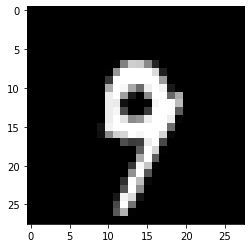

In [3]:
images, labels = next(iter(train_loader))

i = np.random.randint(0,99)
## Analize the inputs by plotting one image

img = images[i]
print("label: ", int(labels[i]))
img = np.array(img, dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

Wonderful! Now let’s try displaying a full batch of images!

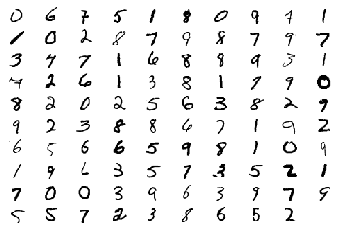

In [4]:
## Display one batch of images
figure = plt.figure()
num_of_images = batch_size

for index in range(1, num_of_images):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].reshape((28, 28)).numpy().squeeze(), cmap='gray_r')

## The network architecture
It’s now time to create our neural network. The idea is to implement a simple supervised feed-forward network which trough back-propagation will adjust its state in order to define which digit our input image represent. We have seen that our inputs are composed by 784 values. Therefore, it’s obvious to pick the dimension of our input layer accordingly. The outer layer has to represent which digit we gave in input, thus we choose the dimension of 10 neurons. As for the activation function in the hidden layers, we'll use *ReLU* over *sigmoid* since it achieves a better representation trough sparsity. *ReLU* is also less likely to suffer from gradient vanishing, but with two layer it’s not a real problem anyway. The last layer goes trough a *Softmax* function. The *Softmax* function calculates the probabilities distribution of the value of the image, over the 10 different outputs. The range will be from 0 to 1 and the sum of all probabilities will be equal to 1. This is going to be helpful when we’re going to examine which probabilities has every single digit over an image. The loss criterion used is the *Cross Entropy* loss function. This loss function measures the performance of a classification model whose output is a probability value between 0 and 1, as in our case.

In [5]:
## Fully connected NN with 2 hidden layers using ReLU
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.soft = nn.LogSoftmax(dim=1)
        self.act = nn.ReLU()
        
    def forward(self, x): 
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))     
        out = self.soft(self.fc3(x))
        return out
    

A slightly different implementation of the network add *dropout* on the hidden layers. Trough dropout, we randomly drop a unit and all its connections. The drop happens with a fixed probability of 0.5. The implementation of dropout doesn’t change the network architecture, but instead set to zero the output of the node we chose to drop. This implementation perform slightly better than the standard implementation, thus is suggested to utilize. Try by yourself how the performance change by implementing both!

In [6]:
## Fully connected NN with 2 hidden layers using ReLU and dropout on hidden layers
class Net_dropout(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        super().__init__()
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        self.soft = nn.LogSoftmax(dim=1)
        self.act = nn.ReLU()
        
    def forward(self, x): 
        
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))        
        out = self.soft(self.fc3(x))
        
        return out


This function is used later on to display the input images and the probabilities of the activations of the 10 output layers. 

In [7]:
##Print the digit and the probabilities of activation in the last layer
def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

## Training and testing the network
Let's now define the training procedure! During the train, images get passed trough the network during the forward propagation. Then the loss between the prediction and the correct labels gets calculated, and we do a back-propagation of the error. Finally, we update the weights of our network. During the train, we calculate the losses of the training set, to monitor the learning of our model.

In [8]:
##Define the loss function used by the network
loss_fn = nn.CrossEntropyLoss()

train_loss, training_loss_mean = [], []

## Define the training procedure
def net_train(num_epochs, lr, model, train_loader):
    
    ## Define a SGD optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(num_epochs):

        for images, labels in train_loader:
            
            #Reshape the array
            image = images.view(images.shape[0], -1)
           
            # zero the parameter gradients
            optimizer.zero_grad()
        
            ## forward propagation
            output = model(image)
            
            ## loss calculation
            loss = loss_fn(output, labels)
        
            ## backward propagation
            loss.backward()
        
            ## weight optimization
            optimizer.step()
            
            ## store the loss on the training
            train_loss.append(loss.item())
            training_loss_mean.append(np.mean(train_loss))
    
        print ("Epoch: ", epoch, "Training Loss: ", np.mean(train_loss))
        
    return np.mean(train_loss)


Below we have the function used for testing our data. This return us the % accuracy over the samples. 

In [9]:
##Try the model on the unseen test set
test_loss, test_loss_avg = [], []

def net_test(model,  test_loader):
    
    model.eval()
    with torch.no_grad():
        
        total, correct = 0, 0
        c = 0
        
        for (images, labels) in test_loader:
            
            #Reshape the array
            image = images.view(images.shape[0], -1) 
            
            for i in range (len(labels)):
                
                output = model(image)
                
                loss = loss_fn(output, labels.squeeze())
                
                test_loss.append(loss.item())
                test_loss_avg.append(np.mean(test_loss))
                
                _, predicted = torch.max(output.data, 1)
                correct += (predicted.data[i].item() == labels.data[i].item())
                
            total += labels.size(0)
            
    #Print the accuracy of the network
    print('Accuracy of the network on the ', total, ' test images: {} %'.format(100*correct / total))

## Hyperparameters research
As probably many of the readers of this notebook know, an important part of creating a Neural network is the research of the best hyperparameters. Here we choose to use a *random search* to search for various configurations of the model by varying the learning rate and the number of epochs. In the end we choose the ones that implies the minimum training error. Just for the sake of testing, we are going to consider 200 neurons in the hidden layers.

In [10]:
## numbers of conbinations of hyperparameters to try
num_iters = 10
maximum = 0

loss_store, lr_store, epoch_store = [], [], []
Ni = 784
Nh1 = 200
Nh2 = 200
No = 10

best_lr, best_epochs = 0,0 

## Random search - Long time to process, excute only when researching hyperparameters!!!
for i in range(num_iters):   
    #Initialize the network
    model = Net(Ni, Nh1, Nh2, No)
    
    #Set random parameters
    rand_lr = random.randint(1,5)*(10**(-random.randint(2,6)))
    rand_epoch = (random.randint(2,20))
    print("iteration: ", i, " lr: ", rand_lr, "and #epoch: ", rand_epoch)
    
    #Compute the training
    loss = net_train(rand_epoch, rand_lr, model, train_loader)
    
    ##Store the parameters
    loss_store.append(loss)
    lr_store.append(rand_lr)
    epoch_store.append(rand_epoch)
    
    ## Update the best parameters
    if(i == 0): maximum = loss
    elif (loss < maximum):
        best_lr = rand_lr
        best_epochs = rand_epoch
        maximum = loss
        print("The best loss so far is: ", maximum, " with lr: ", rand_lr, "and #epoch: ", rand_epoch)

iteration:  0  lr:  4.9999999999999996e-06 and #epoch:  9
Epoch:  0 Training Loss:  2.1111236693461737
Epoch:  1 Training Loss:  1.8256825362642606
Epoch:  2 Training Loss:  1.5621413633889623
Epoch:  3 Training Loss:  1.3619480717430512
Epoch:  4 Training Loss:  1.212392511487007
Epoch:  5 Training Loss:  1.0980452175190052
Epoch:  6 Training Loss:  1.0082121491893417
Epoch:  7 Training Loss:  0.9359230389601241
Epoch:  8 Training Loss:  0.8765245817022191
iteration:  1  lr:  0.00030000000000000003 and #epoch:  19
Epoch:  0 Training Loss:  0.8272457060317199
Epoch:  1 Training Loss:  0.7662492425262815
Epoch:  2 Training Loss:  0.7113334897622311
Epoch:  3 Training Loss:  0.6627921237994749
Epoch:  4 Training Loss:  0.6200261211226739
Epoch:  5 Training Loss:  0.5820477582344061
Epoch:  6 Training Loss:  0.5482159513534377
Epoch:  7 Training Loss:  0.5179642168056408
Epoch:  8 Training Loss:  0.49071799153947115
Epoch:  9 Training Loss:  0.46608757047945115
Epoch:  10 Training Loss:  

KeyboardInterrupt: 

Let's see how our random search parameters turned out on a nice plot!

No handles with labels found to put in legend.


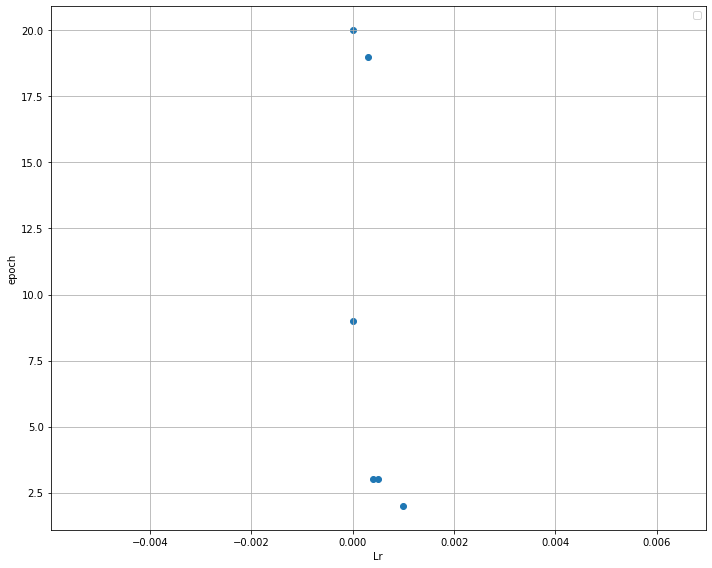

In [12]:
##Plot random search configuration
plt.close('all')
plt.figure(figsize=(10,8))
plt.scatter(lr_store, epoch_store)
plt.xlabel('Lr')
plt.ylabel('epoch')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Now that we've found some nice values of lr and epochs, let's compute the actual training! In particular, we consider the network using dropout with 1000 neurons in the first hidden layer and 800 neurons in the second hidden layer. We can also compute the train without using dropout by using *Net()* instead of *Net_dropout()*.

In [13]:
##Train on network with dropout enabled
Nh1 = 1000
Nh2 = 800
model = Net_dropout(Ni, Nh1, Nh2, No)
net_train(best_epochs, best_lr, model, train_loader)

Epoch:  0 Training Loss:  0.6855719321033988
Epoch:  1 Training Loss:  0.677357623617162


0.677357623617162

In [14]:
## Train the network without using dropout
#Nh1 = 200
#Nh2 = 200
#model = Net(Ni, Nh1, Nh2, No)
#net_train(best_epochs, best_lr, model, train_loader)

It's time to check how our model perform on unseen data. Trough the call of the *net_test()* function we'll know what the accuracy of our network actually is. 

In [15]:
## Test the network
net_test(model, test_loader)

Accuracy of the network on the  10000  test images: 96.97 %


## Study the output
We have finally trained and tested our network. What now? 
Well, since this is a student-like approach to the problem, we are going to go deeper into the actual "stuff" our network is doing. Let's start by analizing the output. We have defined the use of a *Softmax* function in the last layer, so we actually expect to obtain some probabilities on the neurons in the last layer. Let's display now some input images with the corresponding output layer. Particular attention must be given to the images our network failed to correctly classify. Look at how the probabilities are actually describing what our model think is the correct digit. 

Predicted Digit = 1  True digit=  1
Predicted Digit = 7  True digit=  7
Predicted Digit = 0  True digit=  0
Predicted Digit = 0  True digit=  0
Predicted Digit = 3  True digit=  3
Predicted Digit = 9  True digit=  9
Predicted Digit = 6  True digit=  6
Predicted Digit = 3  True digit=  3
Predicted Digit = 9  True digit=  9
Predicted Digit = 7  True digit=  7
Predicted Digit = 9  True digit=  9
Predicted Digit = 5  True digit=  5
Predicted Digit = 5  True digit=  5
Predicted Digit = 7  True digit=  7
Predicted Digit = 2  True digit=  2
Predicted Digit = 3  True digit=  3
Predicted Digit = 8  True digit=  8
Predicted Digit = 6  True digit=  6
Predicted Digit = 5  True digit=  5
Predicted Digit = 2  True digit=  2


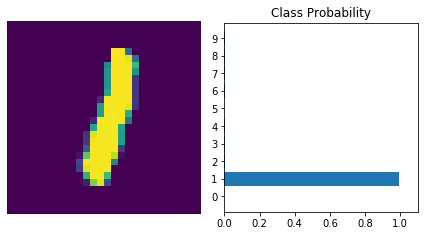

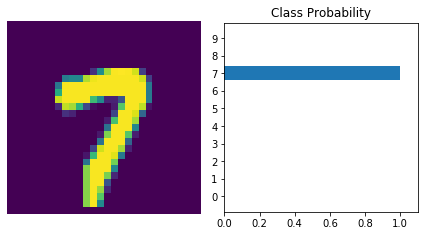

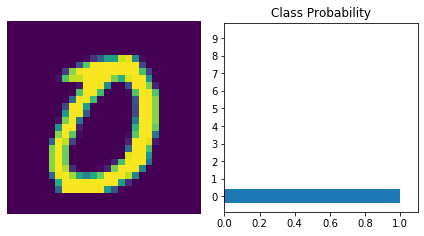

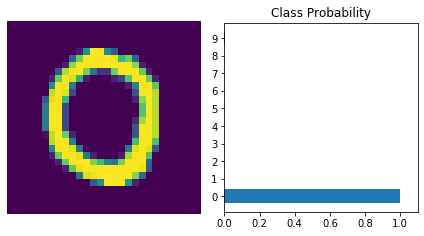

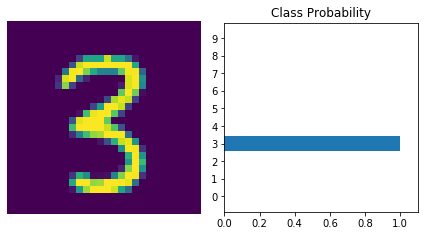

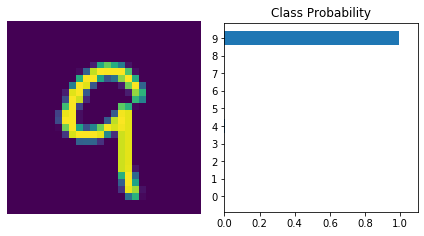

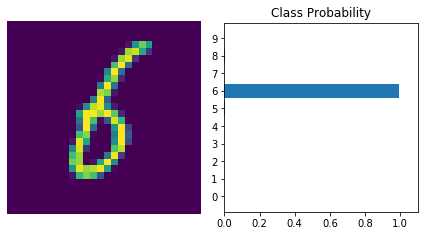

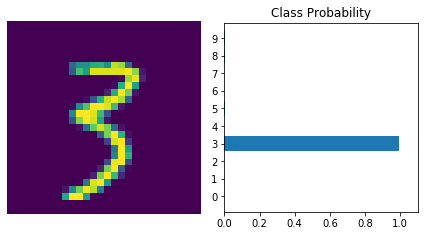

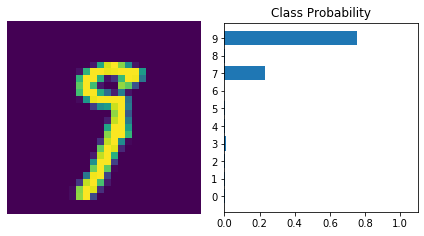

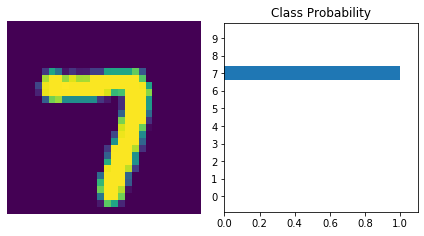

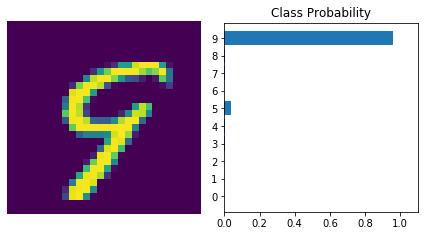

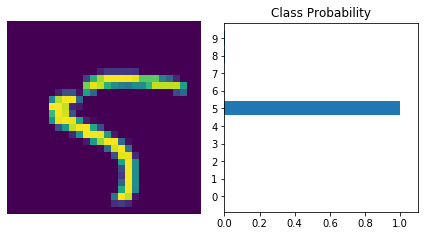

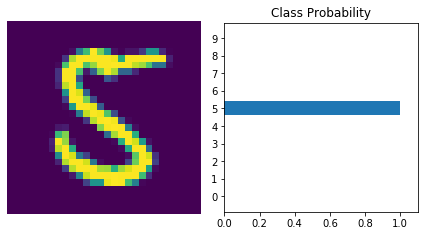

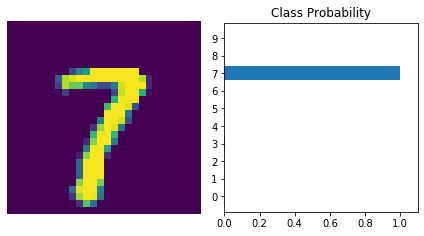

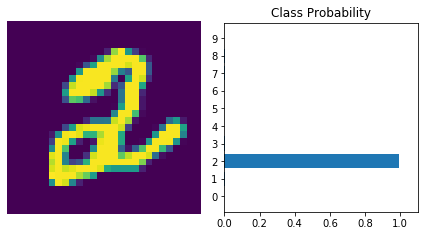

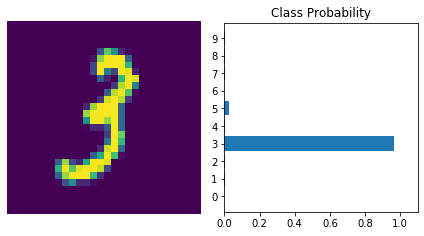

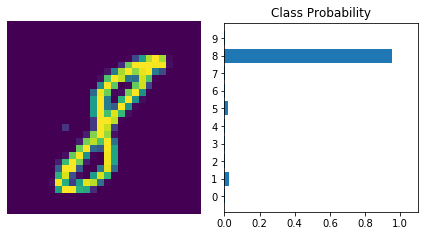

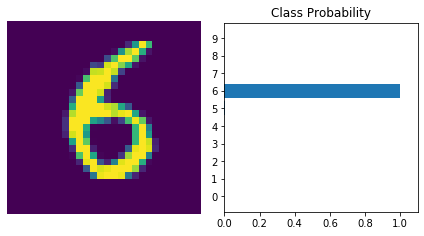

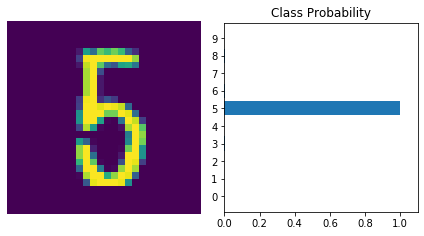

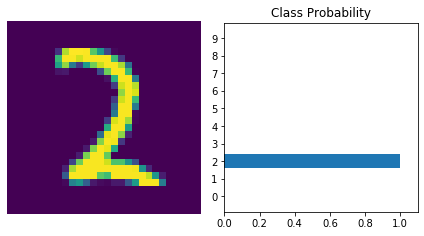

In [16]:
for i in range (80, 100):
    #resize
    img = images[i].view(1, 784)
    
    # Compute the 
    with torch.no_grad():
        ps = model(img)
    # To get probabilities we compute exp of the output 
    ps = torch.exp(ps)
    probab = list(ps.numpy()[0])
    
    #Print results
    print("Predicted Digit =", probab.index(max(probab)), " True digit= ", int(labels[i]))
    view_classify(img.view(1, 28, 28), ps)

Another interesting thing to plot are the weights of our model. Since this is a simple network, we can actually linearly combine the weights of the neurons to extract some "features" which are encoded by that specific neuron. 

In [17]:
#Return shapes of the parameters of our net
for name, param in model.named_parameters():
    print(name, '\t\t', param.shape)
    
#Get the network parameters
params = list(model.parameters())

fc1.weight 		 torch.Size([1000, 784])
fc1.bias 		 torch.Size([1000])
fc2.weight 		 torch.Size([800, 1000])
fc2.bias 		 torch.Size([800])
fc3.weight 		 torch.Size([10, 800])
fc3.bias 		 torch.Size([10])


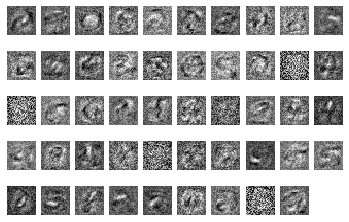

In [18]:
#Plot the weights matrix of the first 50 connections   
for i in range (1,50):
    img = params[0][i].view(1, 784)
    img = img.detach().numpy()
    pixels = img.reshape((28, 28))  
    plt.subplot(5, 10, i)
    plt.axis('off')
    plt.imshow(pixels.squeeze(), cmap='gray_r')

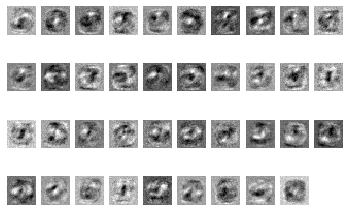

In [19]:
#Compute the product between W1 and W2j weights matrix and plot
for i in range (1,40): 
    mul = params[2][i].matmul(params[0])
    img = mul.view(1, 784)
    img = img.detach().numpy()
    pixels = img.reshape((28, 28)) 
    plt.subplot(4, 10, i)
    plt.axis('off')
    plt.imshow(pixels, cmap='gray_r')


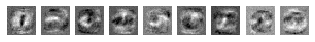

In [20]:
mul0 = params[2].matmul(params[0])

#Compute the product between W1,W2 and W3j weights matrix and plot
for i in range (1,10): 
    mul = params[4][i].matmul(mul0)
    img = mul.view(1, 784)
    img = img.detach().numpy()
    pixels = img.reshape((28, 28))
    plt.subplot(1, 10, i)
    plt.axis('off')
    plt.imshow(pixels.squeeze(), cmap='gray_r')